# Graphing Semantic Networks : Retrieval Induced Forgetting

In [1]:
import sys
sys.path.insert(1, '../')
from graphsemnet.gsn import compute_nmph, spread_activation, rect, compute_adjacency
from scipy.special import expit
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
sns.set_context('notebook')
sns.set_style('whitegrid')

NMPH function
$$
h\left(x~|~y_{min}, y_{max}, x_{cp}, y_{cp}\right) = \begin{cases}
2 x \left(y_{min}/x_{cp}\right) & x \leq x_{\text{cp}/2}\\
2 x \left(y_{cp} - y_{min}\right)/x_{cp} & x_{\text{cp}/2} < x \leq x_{\text{cp}}\\
x \left(y_{max} - y_{cp}\right)/\left(1 - x_{\text{cp}}\right) & x_{\text{cp}} < x \leq 1
\end{cases}
$$

Let $W_0, \text{ACT}_0$ be the initial conditions

Weight update

$$
W_k = f\left(W_{k-1} + \alpha~h\left(\text{ACT}_{k-1}^{T}\right) \circ A \right)
$$

Activation update

$$
\Delta\text{ACT}_k =  \sum_{i=0}^{k-1}\gamma^i\text{ACT}_{i}\cdot\prod_{d=0}^{i}W_d \\
\text{ACT}_k = f\left(\lambda^k~\text{ACT}_{k-1} + \Delta\text{ACT}_k\right)
$$

- $\circ$, $\Pi$ denote element-wise multiplication
- $\cdot$ denotes dot-product
- $\text{ACT}_i$ is a row vector
- $f(x)$ is an activation function, in our case a ReLU
- $W$: matrix of (thresholded) weights
- $\gamma$: decay parameter
- $\lambda$: decay parameter of previous activations
- $\alpha$: learning parameter

- Todo: extend this with $R^i$ to model second, and third, etc reachability

In [4]:
def noisy_activation(act, sigma_noise=0.1):
    act = np.array(act)
    return rect(act + np.random.normal(scale=sigma_noise, size=act.shape))

In [5]:
def filter_activation(activation):
    a = rect(activation.copy())
    #a = rect(nmph(a))
    a /= a.sum()
    return a.flatten()

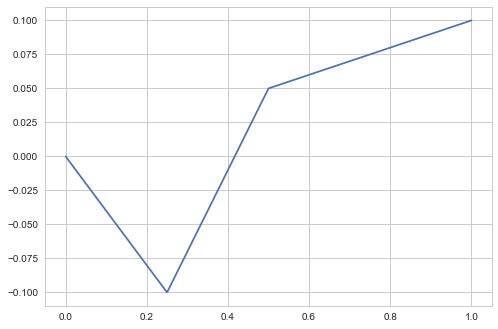

In [6]:
nmph = compute_nmph(-0.1, .5, .05, .1)
x = np.linspace(0, 1, 1000)
y = nmph(x)
plt.plot(x, y);

In [7]:
def run_experiment_subject(gamma, alpha, depth, lambda_, nmph, n_iter=1000, sigma_noise=0.01):
    winner_iter = []
    # Phase 1: Study
    W = np.zeros((6, 6))
    W[0, 1] = 0.5
    W[0, 2] = 0.5

    W[3, 4] = 0.5
    W[3, 5] = 0.5
    W += W.T

    for i in range(n_iter):
        # Phase 2: Retrieval Practice
        # We want horse
        ACT_pr = np.array([1, .25, 0, 0, 0, 0])[None, :] # we want a row vector
        # Add noise on activation
        ACT_pr = noisy_activation(ACT_pr, sigma_noise=sigma_noise)
        W_ = W
        for _ in range(1):
            Ws, ACT = spread_activation(W_, ACT_pr, nmph, 
                                        gamma=gamma, alpha=alpha, lambda_=lambda_, d=depth)
            W_ = Ws[-1]

        # Phase 3: Test
        W_te = Ws[-1]
        ACT_rpplus = noisy_activation(np.array([1, .1, 0, 0, 0, 0])[None, :], sigma_noise)
        ACT_rpminus = noisy_activation(np.array([1, 0, .1, 0, 0, 0])[None, :], sigma_noise)
        ACT_nrp1 = noisy_activation(np.array([0, 0, 0, 1, .1, 0])[None, :], sigma_noise)
        ACT_nrp2 = noisy_activation(np.array([0, 0, 0, 1, 0, .1])[None, :], sigma_noise)

        winners = []
        for activation, which in zip([ACT_rpplus, ACT_rpminus, ACT_nrp1, ACT_nrp2], [1, 2, 4, 5]):
            _, activation_ = spread_activation(W_te, activation, nmph, 
                                               gamma=gamma, alpha=alpha, lambda_=lambda_, d=depth)
            # do not consider the one we activated
            which_active = np.argmax(activation)
            last_activation = activation_[-1]
            # do not look at the category we ping'd
            last_activation[0][which_active] = 0.
            #prob_activation = filter_activation(last_activation, nmph)
            # probabilistic response
            #n_responses = 10
            #responses = np.random.choice(range(6), n_responses, p=prob_activation)
            #winners.append(np.sum(responses == which)/n_responses)
            winners.append((np.argmax(last_activation) == which).astype(int))
            #winners.append((activation_[-1][which] > 0.5).astype(int))
        winner_iter.append(winners)

    winner_iter = np.array(winner_iter)

    #rpplus = np.sum(winner_iter[:, 0] == 1)/n_iter
    #rpminus = np.sum(winner_iter[:, 1] == 2)/n_iter
    #nrp = (np.sum(winner_iter[:, 2] == 4)/n_iter + np.sum(winner_iter[:, 3] == 5)/n_iter)/2.
    return winner_iter

In [8]:
depth = 3
gamma = 0.8
alpha = 0.5
n_iter = 1000
sigma_noise = 0.1
lambda_ = 1

In [83]:
# Simulate twenty subjects
def simulate_experiment(gamma=0.8, alpha=0.5, depth=3, lambda_=1, nmph=compute_nmph(-0.1, .5, .05, .1), n_iter=1000,
                       sigma_s=0.2, n_subj=20, seed=432):
    exp_subj = []
    sigma_subj = []
    for i in range(n_subj):
        print("Subject {0}".format(i))
        # sample noise
        sigma_noise = np.random.normal(scale=sigma_s)
        exp = run_experiment_subject(gamma, alpha, depth, lambda_, nmph, n_iter=n_iter, sigma_noise=sigma_s)
        exp_subj.append(np.sum(exp, axis=0)/n_iter)
        sigma_subj.append(sigma_noise)
    return exp_subj, sigma_subj

In [90]:
gammas = np.arange(0, 1.1, 0.1)

In [115]:
exp_subj_dict = dict()
for gamma in gammas:
    print("## SIMULATING WITH GAMMA {0}".format(gamma))
    exp_subj, sigma_subj = simulate_experiment(gamma=gamma)
    exp_subj_dict[gamma] = exp_subj

## SIMULATING WITH GAMMA 0.0
Subject 0
Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
## SIMULATING WITH GAMMA 0.1
Subject 0
Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
## SIMULATING WITH GAMMA 0.2
Subject 0
Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
## SIMULATING WITH GAMMA 0.30000000000000004
Subject 0
Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
## SIMULATING WITH GAMMA 0.4

In [116]:
def make_dataframe(exp_subj):
    data = np.vstack(exp_subj)
    data = np.hstack((data[:, :2], np.mean(data[:, 2:], axis=1)[:, None]))
    df = pd.DataFrame(data, columns=['Rp+', 'Rp-', 'NRp'])
    df_ = pd.melt(df)
    return df_

In [117]:
dfs = {np.round(g, 2): make_dataframe(exp_subj_dict[g]) for g in exp_subj_dict.keys()}

In [126]:
def plot_violin(gamma):
    ax = sns.violinplot(x='variable', y='value', data=dfs[gamma], inner='point')
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("")
    ax.set_ylim(0.2, 0.95)
    sns.despine()

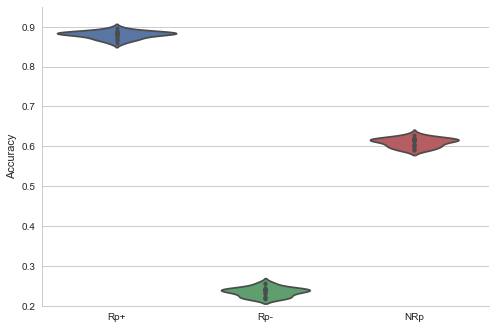

In [127]:
gamma_slider = widgets.FloatSlider(min=gammas[0], max=gammas[-1], step=0.1, start=0)
w = interactive(plot_violin, gamma=gamma_slider)
display(w)

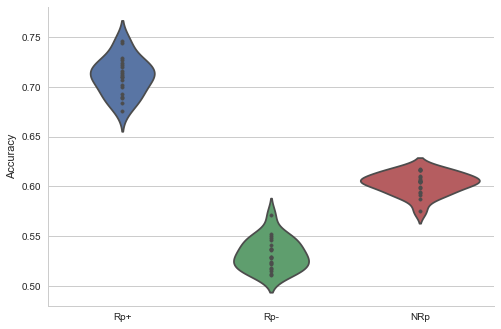

In [87]:
ax = sns.violinplot(x='variable', y='value', data=df, inner='point')
ax.set_ylabel("Accuracy")
ax.set_xlabel("")
#ax.set_ylim(0, 1)
sns.despine()

# Visualize 

In [167]:
import networkx as nx
from matplotlib.colors import Normalize
from seaborn.utils import relative_luminance

In [158]:
cmap = sns.cubehelix_palette(light=.95, as_cmap=True)
norm = Normalize(vmin=0, vmax=1)

In [179]:
def plot_network_activation(W, ACT, ax=None):
    pos = {
        0 : [0, .05],
        1: [-1, 0],
        2: [1, 0],
        3: [3, .05],
        4: [2, 0],
        5: [4, 0]
        }
    sns.set_style("ticks")
    #G = nx.DiGraph(W)
    G = nx.Graph(W)
    colors = [cmap(norm(a)) for a in ACT.flatten()]
    luminance_colors = [relative_luminance(c) for c in colors]
    text_colors = [".15" if l > .408 else "w" for l in luminance_colors]
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    nx.draw_networkx(G, pos=pos, ax=ax, node_size=ACT*2000 + 300, node_color=colors)
    # change color of the text
    for t, c in zip(ax.texts, text_colors):
        t.set_color(c)
    sns.despine(left=True, bottom=True)
    ax.set_axis_off()
    ax.set_ylim([-.1, .1])
    ax.set_xlim([-1.5, 5])
    return ax

In [135]:
def plot_activation_single(W, ACT, ax=None, figsize=(20, 4)):
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=figsize)
    plot_network_activation(W, ACT, ax=ax[0])
    sns.heatmap(W, annot=True, vmin=0, vmax=1, ax=ax[2], square=True, cbar=False)
    sns.heatmap(ACT, annot=True, vmin=0, vmax=1, ax=ax[1], cbar=False)
    return ax

In [56]:
def plot_activation(Ws, ACT, figsize=(20, 14)):
    n_depth = len(Ws)
    fig, axs = plt.subplots(n_depth, 2, figsize=figsize)
    for W_, ACT_, ax in zip(Ws, ACT, axs):
        plot_activation_single(W_, ACT_, ax=ax)
    return fig

In [14]:
W = np.zeros((6, 6))
W[0, 1] = 0.5
W[0, 2] = 0.5

W[3, 4] = 0.5
W[3, 5] = 0.5
W += W.T

In [16]:
A = noisy_activation([1, .25, 0, 0, 0, 0])

In [19]:
sigma_noise = 0.1

In [20]:
winner_iter = []
# Phase 1: Study
W = np.zeros((6, 6))
W[0, 1] = 0.5
W[0, 2] = 0.5

W[3, 4] = 0.5
W[3, 5] = 0.5
W += W.T

n_iter = 1
for i in range(n_iter):
    # Phase 2: Retrieval Practice
    # We want horse
    ACT_pr = np.array([1, .25, 0, 0, 0, 0])[None, :] # we want a row vector
    # Add noise on activation
    ACT_pr = noisy_activation(ACT_pr, sigma_noise=sigma_noise)
    W_ = W
    for _ in range(1):
        Ws, ACT = spread_activation(W_, ACT_pr, nmph, 
                                    gamma=gamma, alpha=alpha, lambda_=lambda_, d=depth)
        W_ = Ws[-1]

    # Phase 3: Test
    W_te = Ws[-1]
    ACT_rpplus = noisy_activation(np.array([1, .1, 0, 0, 0, 0])[None, :], sigma_noise)
    ACT_rpminus = noisy_activation(np.array([1, 0, .1, 0, 0, 0])[None, :], sigma_noise)
    ACT_nrp1 = noisy_activation(np.array([0, 0, 0, 1, .1, 0])[None, :], sigma_noise)
    ACT_nrp2 = noisy_activation(np.array([0, 0, 0, 1, 0, .1])[None, :], sigma_noise)

    winners = []
    for activation, which in zip([ACT_rpplus, ACT_rpminus, ACT_nrp1, ACT_nrp2], [1, 2, 4, 5]):
        Ws_te, activation_ = spread_activation(W_te, activation, nmph, 
                                           gamma=gamma, alpha=alpha, lambda_=lambda_, d=depth)
        # do not consider the one we activated
        which_active = np.argmax(activation)
        last_activation = activation_[-1]
        # do not look at the category we ping'd
        last_activation[0][which_active] = 0.
        #prob_activation = filter_activation(last_activation, nmph)
        # probabilistic response
        #n_responses = 10
        #responses = np.random.choice(range(6), n_responses, p=prob_activation)
        #winners.append(np.sum(responses == which)/n_responses)
        winners.append((np.argmax(last_activation) == which).astype(int))
        #winners.append((activation_[-1][which] > 0.5).astype(int))
    winner_iter.append(winners)

winner_iter = np.array(winner_iter)

In [32]:
sns.set_context('notebook')

In [ ]:
from IPython.wi

In [131]:
def plot_interactive_activation(d):
    plot_activation_single(Ws[d], ACT[d], figsize=(14, 4));
    plt.tight_layout()  

In [71]:
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets

In [72]:
from IPython.display import display

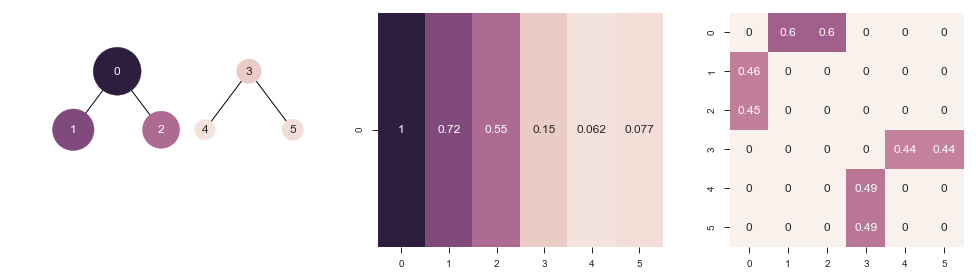

In [181]:
d_slider = widgets.IntSlider(min=0, max=2, step=1, value=0)
w = interactive(plot_interactive_activation, d=d_slider)
display(w)

In [80]:
interactive??

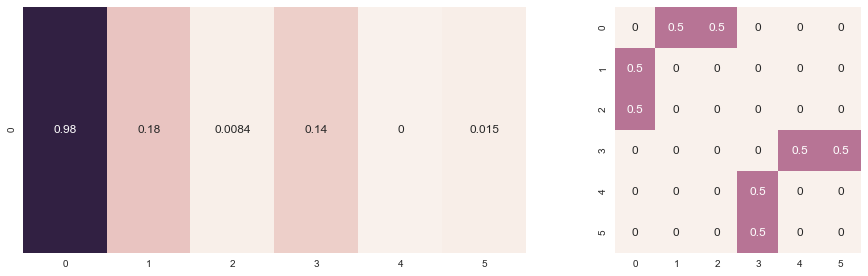

In [79]:
display(w)

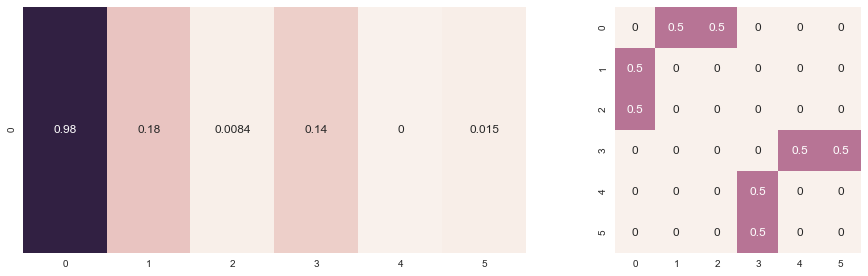

In [69]:
plot_activation_single(Ws[0], ACT[0], figsize=(14, 4));
plt.tight_layout()

In [63]:
%debug

> /Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/matrix.py(495)heatmap()
    493         ax = plt.gca()
    494     if square:
--> 495         ax.set_aspect("equal")
    496     plotter.plot(ax, cbar_ax, kwargs)
    497     return ax

ipdb> u
> <ipython-input-55-b60408ebce60>(4)plot_activation_single()
      1 def plot_activation_single(W, ACT, ax=None, figsize=(20, 4)):
      2     if ax is None:
      3         ax = plt.subplots(1, 2, figsize=figsize)
----> 4     sns.heatmap(W, annot=True, vmin=0, vmax=1, ax=ax[1], square=True, cbar=False)
      5     sns.heatmap(ACT, annot=True, vmin=0, vmax=1, ax=ax[0], cbar=False)

ipdb> print(ax)
(<matplotlib.figure.Figure object at 0x113e956a0>, array([<matplotlib.axes._subplots.AxesSubplot object at 0x112cf6e10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1125687b8>], dtype=object))
ipdb> q


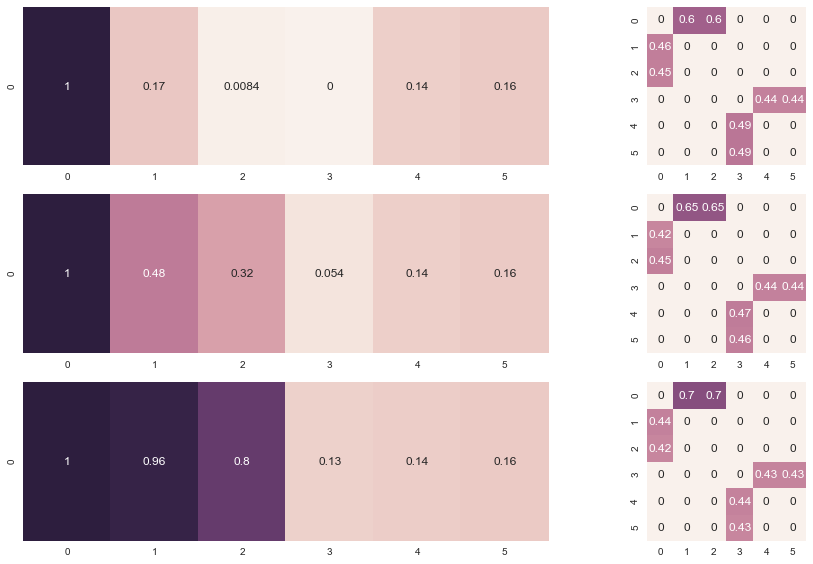

In [50]:
Ws_te, ACT_te = spread_activation(Ws[-1], ACT_rpplus, nmph, 
                                  gamma=gamma, alpha=alpha, lambda_=lambda_, d=depth)
plot_activation(Ws_te, ACT_te, figsize=(14, 8));
plt.tight_layout();

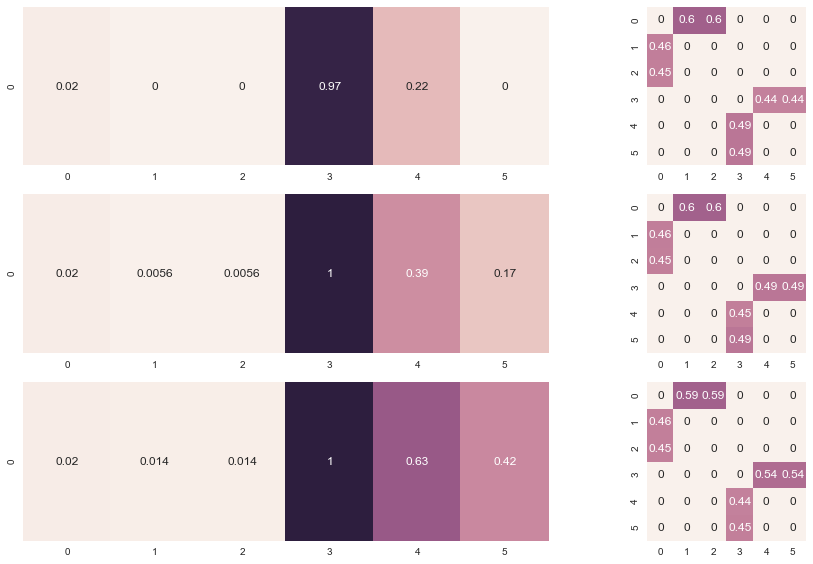

In [51]:
Ws_te, ACT_te = spread_activation(Ws[-1], ACT_nrp1, nmph, 
                                  gamma=gamma, alpha=alpha, lambda_=lambda_, d=depth)
plot_activation(Ws_te, ACT_te, figsize=(14, 8));
plt.tight_layout();

In [43]:
which_active = np.argmax(ACT_rpplus)
last_activation = activation_[-1].copy()
# do not look at the category we ping'd
last_activation[0][which_active] = 0.
#prob_activation = filter_activation(last_activation, nmph)
# probabilistic response
#n_responses = 10
#responses = np.random.choice(range(6), n_responses, p=prob_activation)
#winners.append(np.sum(responses == which)/n_responses)
winners.append((np.argmax(nmph(last_activation)) == which).astype(int))

In [44]:
which_active

0

In [31]:
n_depth = len(Ws_)
fig, axs = plt.subplots(n_depth, 2, figsize=(20, 14))
for W_, ACT_, ax in zip(Ws, ACT, axs):
    sns.heatmap(W_, annot=True, vmin=0, vmax=1, ax=ax[0], square=True)
    sns.heatmap(ACT_, annot=True, vmin=0, vmax=1, ax=ax[1])

[array([[ 0.97933679,  0.08289122,  0.        ,  0.        ,  0.        ,
          0.00232719]]),
 array([[  9.83730880e-01,   1.97291502e-01,   1.14400278e-01,
           1.69191977e-04,   0.00000000e+00,   2.32719007e-03]]),
 array([[  9.90380367e-01,   3.35759969e-01,   2.52868745e-01,
           3.63335533e-04,   1.89105007e-06,   2.32908112e-03]])]

In [25]:
winner_iter

array([[0, 0, 0, 0]])

In [28]:
spread_activation??

In [29]:
nmph(ACT[0])

array([[ 0.09850315, -0.09492156,  0.        , -0.00586625, -0.00105197,
         0.        ]])

In [27]:
Ws[-1]

array([[ 0.        ,  0.6       ,  0.6       ,  0.        ,  0.        ,
         0.        ],
       [ 0.42872933,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.48024188,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.49892669,
         0.49892669],
       [ 0.        ,  0.        ,  0.        ,  0.49941534,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.49251406,  0.        ,
         0.        ]])

In [42]:
Ws, ACT = spread_activation(Ws[-1], ACT_pr, nmph, gamma, alpha, depth)

In [43]:
len(Ws)

4

In [44]:
print(depth)

3


In [63]:
a = [1, 0.25, 0.10, 0]
b = [0, 0.25, 0.10, 0]